In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Ariel']
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '25'
mpl.rcParams['ytick.labelsize'] = '25'

In [2]:
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
import astropy.constants as c

In [3]:
data = Table.read('galSpecExtra-dr8.fits')
data_tot = data[data['PLATEID'] > 0]
data_tot = data_tot[data_tot['LGM_TOT_P50'] > -9999]
data_tot = data_tot[data_tot['SPECSFR_TOT_P50'] > -9999]
data_tot = data_tot[data_tot['SFR_TOT_P50'] > -9999]
data_tot = data_tot[data_tot['LGM_FIB_P50'] > -9999]
data_tot = data_tot[data_tot['SPECSFR_FIB_P50'] > -9999]

In [4]:
import seaborn as sns

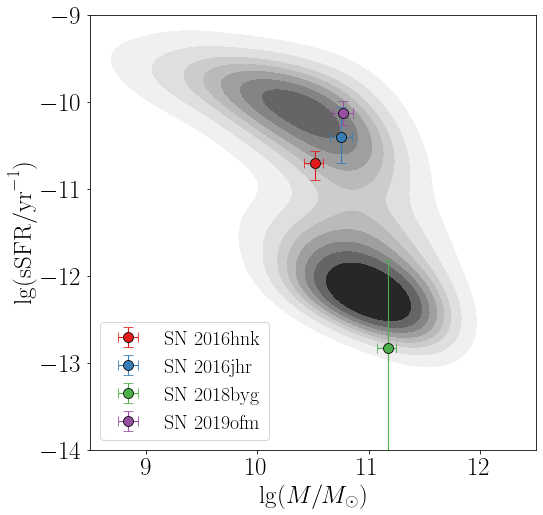

In [5]:
byg = data_tot[data_tot['SPECOBJID'] == '1633681641756977152']
jhr = data_tot[data_tot['SPECOBJID'] == '324379878126282752 ']
ofm = data_tot[data_tot['SPECOBJID'] == '2411848919991478272']
hnk = data_tot[data_tot['SPECOBJID'] == '751129480658970624 ']

plt.figure(figsize=(8, 8))
ax = sns.kdeplot(x=np.array(data_tot['LGM_TOT_P50'][::100], dtype='f4'),
                 y=np.array(data_tot['SPECSFR_TOT_P50'][::100], dtype='f4'),
                 shade=True,
                 cmap="Greys",
                 levels=10)
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
ax.set_xlabel(r'$\lg(M/M_\odot)$')
ax.set_ylabel(r'$\lg(\mathrm{sSFR/yr}^{-1})$')

targets = [hnk, jhr, byg, ofm]
colors = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628'
]
labels = [
    '$\mathrm{SN\ 2016hnk}$', '$\mathrm{SN\ 2016jhr}$',
    '$\mathrm{SN\ 2018byg}$', '$\mathrm{SN\ 2019ofm}$'
]

for k in range(len(targets)):
    if k == 0:  #16hnk (Galbany+2019)
        sfr = 0.649
        lgssfr_l = [-np.log10(1 - 0.234 / sfr)]
        lgssfr_u = [np.log10(1 + 0.234 / sfr)]
        lgssfr = np.log10(sfr) - targets[k]['LGM_TOT_P50']
    else:
        lgssfr = targets[k]['SPECSFR_TOT_P50']
        lgssfr_l = targets[k]['SPECSFR_TOT_P50'] - targets[k]['SPECSFR_TOT_P16']
        lgssfr_u = targets[k]['SPECSFR_TOT_P84'] - targets[k]['SPECSFR_TOT_P50']

    plt.errorbar(
        targets[k]['LGM_TOT_P50'],
        lgssfr,
        fmt='o',
        capsize=5,
        xerr=[
            targets[k]['LGM_TOT_P50'] - targets[k]['LGM_TOT_P16'],
            targets[k]['LGM_TOT_P84'] - targets[k]['LGM_TOT_P50']
        ],
        yerr=[lgssfr_l, lgssfr_u],
        color=colors[k],
        label=labels[k],
        markersize=10,
        markeredgecolor='k',
        markeredgewidth=.8,
        #ecolor='k',
        elinewidth=1.1)

plt.legend(prop={'size': 20}, loc='lower left')
plt.xlim(8.5, 12.5)
plt.ylim(-14, -9)
plt.show()

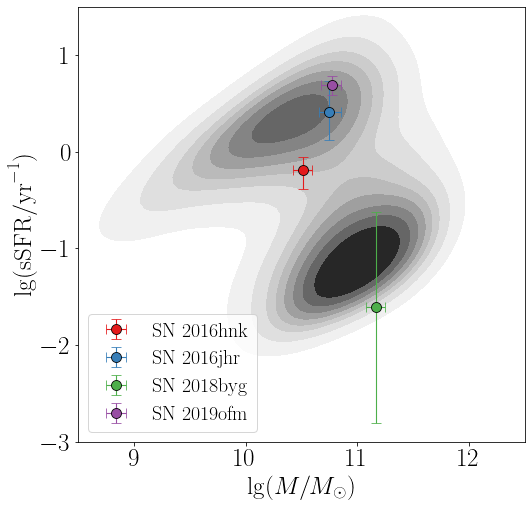

In [6]:
byg = data_tot[data_tot['SPECOBJID'] == '1633681641756977152']
jhr = data_tot[data_tot['SPECOBJID'] == '324379878126282752 ']
ofm = data_tot[data_tot['SPECOBJID'] == '2411848919991478272']
hnk = data_tot[data_tot['SPECOBJID'] == '751129480658970624 ']

plt.figure(figsize=(8, 8))
ax = sns.kdeplot(x=np.array(data_tot['LGM_TOT_P50'][::100], dtype='f4'),
                 y=np.array(data_tot['SFR_TOT_P50'][::100], dtype='f4'),
                 shade=True,
                 cmap="Greys",
                 levels=10)
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
ax.set_xlabel(r'$\lg(M/M_\odot)$')
ax.set_ylabel(r'$\lg(\mathrm{sSFR/yr}^{-1})$')

targets = [hnk, jhr, byg, ofm]
colors = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628'
]
labels = [
    '$\mathrm{SN\ 2016hnk}$', '$\mathrm{SN\ 2016jhr}$',
    '$\mathrm{SN\ 2018byg}$', '$\mathrm{SN\ 2019ofm}$'
]

for k in range(len(targets)):
    if k == 0:  #16hnk (Galbany+2019)
        sfr = 0.649
        lgsfr_l = [-np.log10(1 - 0.234 / sfr)]
        lgsfr_u = [np.log10(1 + 0.234 / sfr)]
        lgsfr = np.log10(sfr)
    else:
        lgsfr = targets[k]['SFR_TOT_P50']
        lgsfr_l = targets[k]['SFR_TOT_P50'] - targets[k]['SFR_TOT_P16']
        lgsfr_u = targets[k]['SFR_TOT_P84'] - targets[k]['SFR_TOT_P50']

    plt.errorbar(
        targets[k]['LGM_TOT_P50'],
        lgsfr,
        fmt='o',
        capsize=5,
        xerr=[
            targets[k]['LGM_TOT_P50'] - targets[k]['LGM_TOT_P16'],
            targets[k]['LGM_TOT_P84'] - targets[k]['LGM_TOT_P50']
        ],
        yerr=[lgsfr_l, lgsfr_u],
        color=colors[k],
        label=labels[k],
        markersize=10,
        markeredgecolor='k',
        markeredgewidth=.8,
        #ecolor='k',
        elinewidth=1.1)

plt.legend(prop={'size': 20}, loc='lower left')
plt.xlim(8.5, 12.5)
plt.ylim(-3, 1.5)
plt.show()

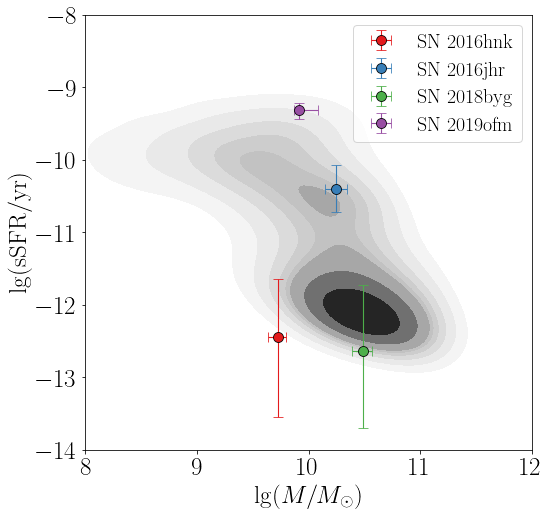

In [7]:
plt.figure(figsize=(8, 8))
ax = sns.kdeplot(x=np.array(data_tot['LGM_FIB_P50'][::100], dtype='f4'),
                 y=np.array(data_tot['SPECSFR_FIB_P50'][::100], dtype='f4'),
                 shade=True,
                 cmap="Greys",
                 levels=10)
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
ax.set_xlabel('$\lg(M/M_\odot)$')
ax.set_ylabel('$\lg(\mathrm{sSFR/yr})$')

targets = [hnk, jhr, byg, ofm]
colors = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628'
]
labels = [
    '$\mathrm{SN\ 2016hnk}$', '$\mathrm{SN\ 2016jhr}$',
    '$\mathrm{SN\ 2018byg}$', '$\mathrm{SN\ 2019ofm}$'
]

for k in range(len(targets)):
    plt.errorbar(
        targets[k]['LGM_FIB_P50'],
        targets[k]['SPECSFR_FIB_P50'],
        fmt='o',
        capsize=5,
        xerr=[
            targets[k]['LGM_FIB_P50'] - targets[k]['LGM_FIB_P16'],
            targets[k]['LGM_FIB_P84'] - targets[k]['LGM_FIB_P50']
        ],
        yerr=[
            targets[k]['SPECSFR_FIB_P50'] - targets[k]['SPECSFR_FIB_P16'],
            targets[k]['SPECSFR_FIB_P84'] - targets[k]['SPECSFR_FIB_P50']
        ],
        color=colors[k],
        label=labels[k],
        markersize=10,
        markeredgecolor='k',
        markeredgewidth=.8,
        #ecolor='k',
        elinewidth=1.1)

plt.legend(prop={'size':20})
plt.xlim(8, 12)
plt.ylim(-14, -8)
plt.show()